# CPU or GPU 

In [ ]:
# !pip uninstall mne
# pip install entropy
# !pip install --upgrade entropy

In [1]:
import tensorflow as tf
# Configuración de TensorFlow para usar la GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# # Configuración de TensorFlow para usar la CPU
# tf.config.set_visible_devices([], 'GPU')

# LIBRARIES 

In [2]:
# !pip list

In [3]:
# Library EEG
import mne

# Library System 
import os
import numpy as np
from tqdm import tqdm
import time

# Library Statistics
import scipy.stats
import random
from scipy.stats import entropy
from scipy.fft import fft
from scipy.signal import welch
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA


# Library GAN
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Library Graph
import matplotlib.pyplot as plt
import seaborn as sns

# No Warning
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("ERROR")

In [4]:
os.getcwd()

'C:\\Users\\macka\\TFM_WD\\ORI\\SEED_GER'

# DATA

### Lista de archivos

In [5]:
# Ruta
emotion = 'POSITIVE'  # 'NEGATIVE' 'NEUTRAL'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEED_GER//01-EEG-raw//SEED_GER//{emotion}'

# 
archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

### Lectura de 1 archivo

In [6]:
electrode_positions= {
    "AF3": (3, 6),
    "FP1": (3, 8),
    "FPZ": (3, 10),
    "FP2": (3, 12),
    "AF4": (3, 14),
    ############
    "F7": (5, 2),
    "F5": (5, 4),
    "F3": (5, 6),
    "F1": (5, 8),
    "FZ": (5, 10),
    "F2": (5, 12),
    "F4": (5, 14),
    "F6": (5, 16),
    "F8": (5, 18),
    ###############
    "FT7": (7, 2),
    "FC5": (7, 4),
    "FC3": (7, 6),
    "FC1": (7, 8),
    # "FCZ": (7, 10),
    "FC2": (7, 12),
    "FC4": (7, 14),
    "FC6": (7, 16),
    "FT8": (7, 18),
    ##############
    "T7": (9, 2),
    "C5": (9, 4),
    "C3": (9, 6),
    "C1": (9, 8),
    "CZ": (9, 10),
    "C2": (9, 12),
    "C4": (9, 14),
    "C6": (9, 16),
    "T8": (9, 18),
    ##############
    "TP7": (11, 2),
    "CP5": (11, 4),
    "CP3":(11, 6),
    "CP1": (11, 8),
    "CPZ": (11, 10),
    "CP2": (11, 12),
    "CP4": (11, 14),
    "CP6": (11, 16),
    "TP8": (11, 18),
    ###############
    "P7": (13, 2),
    "P5":(13, 4),
    "P3":(13, 6),
    "P1":(13, 8),
    "PZ":(13, 10),
    "P2": (13, 12),
    "P4": (13, 14),
    "P6": (13, 16),
    "P8": (13, 18),
    ##############
    "PO7": (15, 4),
    "PO5":(15, 6),
    "PO3": (15, 8),
    "POZ":(15, 10),
    "PO4": (15, 12),
    "PO6": (15, 14),
    "PO8": (15, 16),
    ###############
    "CB1": (17, 6),
    "O1":(17, 8),
    "OZ":(17, 10),
    # "OZ":(17, 12),
    "CB2": (17, 14),
}

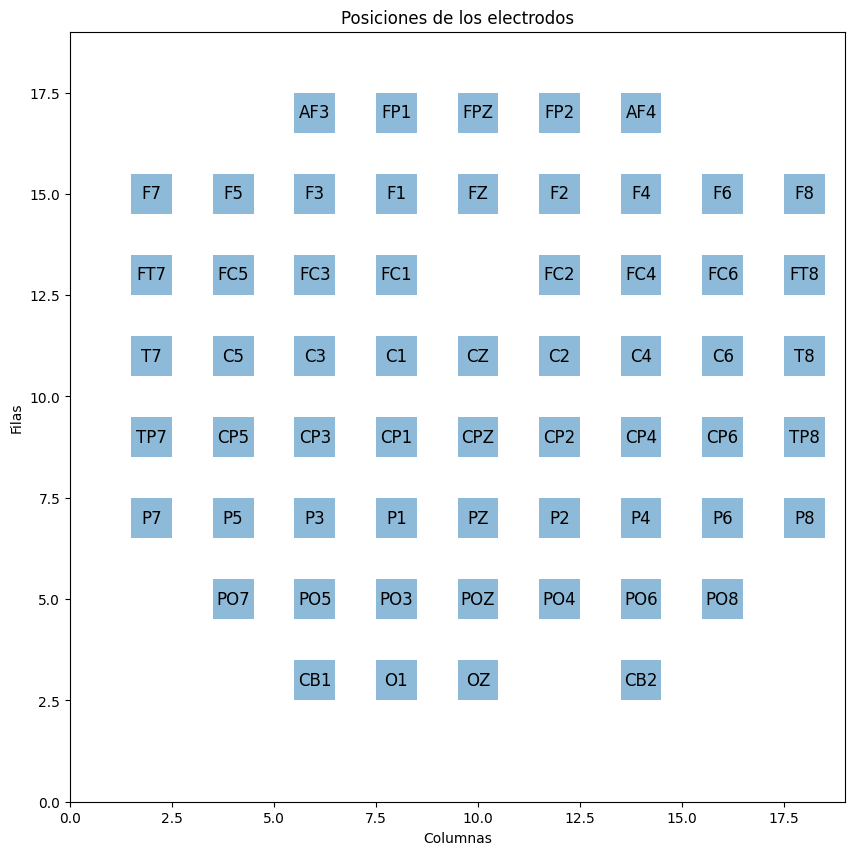

In [7]:
import matplotlib.pyplot as plt
h, w = 19, 19
# Creamos una figura
fig, ax = plt.subplots(figsize=(10, 10))

# Recorremos el diccionario de posiciones y añadimos un cuadrado y el nombre de cada electrodo en su posición reflejada
for electrode, position in electrode_positions.items():
    y,x = position
    x_reflejado = x
    y_reflejado = h - y + 1
    ax.add_patch(plt.Rectangle((x_reflejado - 0.5, y_reflejado - 0.5), 1, 1, fill=True, alpha=0.5))
    ax.text(x_reflejado, y_reflejado, electrode, ha='center', va='center', fontsize=12)

# Configuramos el título, etiquetas de los ejes
ax.set_title('Posiciones de los electrodos')
ax.set_xlabel('Columnas')
ax.set_ylabel('Filas')
ax.set_xlim([0, 19])
ax.set_ylim([0, 19])

# Mostramos la figura
plt.show()

In [31]:
start_time = time.time()  # Record the start time
# Definir los nombres de las bandas de frecuencia
freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30],
              'gamma': [30, 52]}

psd_data = {}
de_data = {}


def differential_entropy(psd):
    de=0.5 * np.log2(2 * np.pi * np.exp(1) * np.mean(psd))
    return de

# Cargar el Archivo
for name in names:
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)

    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_sec = 4
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
    
    # Map 2D
    h, w = 19, 19
    num_freq_bands = len(freq_bands)
    num_channels = len(electrode_positions)
    data_4d = np.zeros((h, w, 2 * num_freq_bands, 2 * win_sec))
    # Inicializar una lista para almacenar los datos de cada banda de frecuencia, DE y PSD
    freq_band_data_list = []
    
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in tqdm(range(total_windows),desc="Procesing...", leaves=False): # 1=total_windows
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia

        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la PSD usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_data[band_name] = psd

            # Calcular la entropía diferencial para la PSD
            de= np.apply_along_axis(differential_entropy, 1, psd)
            de_data[band_name] = de
            
            
elapsed_time = time.time() - start_time
print(f"El código tardó {elapsed_time:.2f} segundos en ejecutarse.")

TqdmKeyError: "Unknown argument(s): {'des': 'Procesing...', 'leaves': False}"

In [ ]:
psd_da

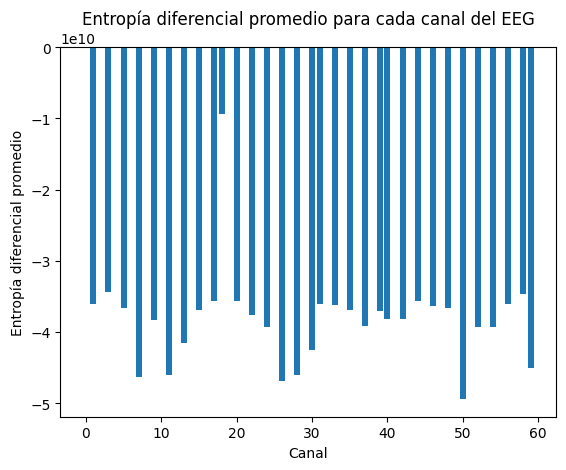

In [15]:
import mne
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Cargar datos del EEG
file = names[0]
file_path = os.path.join(emotion_folder, file)
raw = mne.io.read_raw_fif(file_path, preload=True)

# Preprocesamiento (filtrado y remoción de artefactos)
raw.filter(l_freq=1, h_freq=50)  # Filtrado pasa-banda entre 1 y 50 Hz
# Puedes agregar aquí otros pasos de preprocesamiento si es necesario

# Parametros
segment_duration = 4  # segundos
num_bins = 60  # número de bins para el histograma

# Segmentar la señal
epochs = mne.make_fixed_length_epochs(raw, duration=segment_duration, preload=True)
num_channels = len(epochs.ch_names)
num_segments = len(epochs)

# Calcular la entropía diferencial
entropy = np.zeros((num_channels, num_segments))

for i, epoch in enumerate(epochs):
    for j, channel_data in enumerate(epoch):
        # Estimar la función de densidad de probabilidad (PDF) usando un histograma
        hist, bin_edges = np.histogram(channel_data, bins=num_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Calcular la entropía diferencial para el segmento y canal actual
        pdf_values = hist[np.nonzero(hist)]  # Eliminar valores 0 para evitar log(0)
        entropy[j, i] = -np.sum(pdf_values * np.log2(pdf_values))

# Promediar la entropía diferencial en todos los segmentos
avg_entropy = np.mean(entropy, axis=1)

# Graficar la entropía diferencial promedio para cada canal
plt.bar(range(num_channels), avg_entropy)
plt.xlabel("Canal")
plt.ylabel("Entropía diferencial promedio")
plt.title("Entropía diferencial promedio para cada canal del EEG")
plt.show()


In [17]:
avg_entropy.shape

(60,)

In [ ]:
            for band_idx, band_name in enumerate(freq_bands.keys()):
                for segment_idx in range(1): # 1=total_windows
                    for ch_idx, ch_name in enumerate(filtered_data.ch_names):
                        if ch_name in electrode_positions:
                            x, y = electrode_positions[ch_name]
                            print(f"PSD data dimensions for {band_name}: {psd_data[band_name].shape}")
                            print(f"DE data dimensions for {band_name}: {de_data[band_name].shape}")
                            data_4d[y, x, 2 * band_idx, 2 * segment_idx] = psd_data[band_name][segment_idx][0][ch_idx]
                            data_4d[y, x, 2 * band_idx + 1, 2 * segment_idx + 1] = de_data[band_name][segment_idx][ch_idx]

In [ ]:
def differential_entropy(psd):
    de=0.5 * np.log2(2 * np.pi * np.exp(1) * np.mean(psd))
    return de

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calculate_de_psd(data, sfreq, t_segment, f_ranges):
    n_samples = int(sfreq * t_segment)
    n_segments = data.shape[1] // n_samples
    de_psd = []
    
    for fmin, fmax in f_ranges:
        filtered_data = np.apply_along_axis(butter_bandpass_filter, 1, data, fmin, fmax, sfreq)
        segments = np.array_split(filtered_data, n_segments, axis=1)
        de_psd_band = []
        
        for segment in segments:
            psd, freqs = mne.time_frequency.psd_array_welch(segment, sfreq, fmin=fmin, fmax=fmax, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            de = np.apply_along_axis(differential_entropy, 1, psd)
            de_psd_band.append(de[:, np.newaxis])
        
        de_psd.append(np.concatenate(de_psd_band, axis=1))
    
    return np.stack(de_psd, axis=2)

# Asumiendo que `raw` es un objeto MNE Raw que contiene tus datos EEG
file = names[0]
file_path = os.path.join(emotion_folder, file)

# Cargar los datos EEG
eeg_data = mne.io.read_raw_fif(file_path, preload=True)
data=eeg_data.get_data()
sfreq = eeg_data.info['sfreq']

# Parámetros
t_segment = 1.0  # Duración de cada segmento en segundos
f_ranges = [(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 52)]  # Rangos de frecuencia para las bandas delta, theta, alpha, beta y gamma

# Calcular la representación espacial-espectral-temporal
spatial_spectral_temporal_repr = calculate_de_psd(data, sfreq, t_segment, f_ranges)


In [ ]:
calculate_de_psd(data, sfreq, t_segment, f_ranges)

### 2D

In [ ]:
len(psd_data['delta'][0])

### Ceación Segmento [δ, θ, α, β, γ] =[DE+PSD]

## 

In [ ]:
freq_band_data

In [ ]:
# 1 archivo EEG
file=names[0]
file_path = os.path.join(emotion_folder, file)
eeg_data = mne.io.read_raw_fif(file_path, preload=True)
#eeg_data_list.append(eeg_data.get_data())


In [ ]:
eeg_data.plot(block=True, lowpass=52) #lowpass:muestera frecuencias pord ebajo

In [ ]:
eeg_data.get_data().mean(axis = 1) # Media de Todos los canales.

In [ ]:
eeg_data.set_eeg_reference('average', projection=True)
# Give the sample rate
print('sample rate:', eeg_data.info['sfreq'], 'Hz')
# Give the size of the data matrix
print('%s channels x %s samples' % (len(eeg_data), len(eeg_data.times)))

### Descomposición de 1 archivo

In [ ]:
eeg_data

In [ ]:
# Extract data, from 1 s to 4 s.
sfreq = eeg_data.info['sfreq']
data, times = eeg_data[:, int(sfreq * 0):int(sfreq * 4)]
_ = plt.plot(times, data.T)
_ = plt.title('Sample channels')

plt.show()

In [ ]:
len(times)

### Bandas de Frecuencia.

In [ ]:
# Filtre los datos en bruto para la banda delta (0.5-4 Hz)
eeg_data_delta = eeg_data.copy().filter(l_freq=0.5, h_freq=4)

# Filtre los datos en bruto para la banda theta (4-8 Hz)
eeg_data_theta = eeg_data.copy().filter(l_freq=4, h_freq=8)

# Filtre los datos en bruto para la banda alfa (8-13 Hz)
eeg_data_alpha = eeg_data.copy().filter(l_freq=8, h_freq=13)

# Filtre los datos en bruto para la banda beta (13-30 Hz)
eeg_data_beta = eeg_data.copy().filter(l_freq=13, h_freq=30)

# Filtre los datos en bruto para la banda gamma (30-52 Hz)
eeg_data_gamma = eeg_data.copy().filter(l_freq=30, h_freq=100)

### DE y PSD

# GANs

In [ ]:
start_time = time.time()
# 1. Cargar y preparar los datos
emotion = 'POSITIVE'  # 'NEGATIVE' 'NEUTRAL'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEED_GER//01-EEG-raw//SEED_GER//{emotion}'
file_list = [file for file in os.listdir(emotion_folder) if file.endswith('.fif')]

eeg_data_list = []
for file in file_list:
    file_path = os.path.join(emotion_folder, file)
    eeg_data = mne.io.read_raw_fif(file_path, preload=False)
    eeg_data_list.append(eeg_data.get_data())

# Determine the common length for interpolation
common_length = 50000  # You can adjust this value depending on your needs

interpolated_eeg_data_list = []

for eeg_data in eeg_data_list:
    num_channels = eeg_data.shape[0]
    original_length = eeg_data.shape[1]
    new_eeg_data = np.zeros((num_channels, common_length), dtype=np.float32)

    for ch_idx in range(num_channels):
        x_original = np.linspace(0, 1, original_length)
        x_new = np.linspace(0, 1, common_length)
        new_eeg_data[ch_idx] = np.interp(x_new, x_original, eeg_data[ch_idx])

    interpolated_eeg_data_list.append(new_eeg_data)

eeg_data_tensor = np.stack(interpolated_eeg_data_list, axis=0).astype(np.float32)
eeg_data_tensor = (eeg_data_tensor - np.min(eeg_data_tensor)) / (np.max(eeg_data_tensor) - np.min(eeg_data_tensor)) * 2 - 1

# 2. Crear el modelo GAN
# Generador
def build_generator(latent_dim):
    input_layer = Input(shape=(latent_dim,))
    
    x = Dense(64)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(np.prod(eeg_data_tensor.shape[1:]), activation='tanh')(x)
    output_layer = Reshape(eeg_data_tensor.shape[1:])(x)

    return Model(input_layer, output_layer)

# Discriminador
def build_discriminator():
    input_layer = Input(shape=eeg_data_tensor.shape[1:])
    x = Flatten()(input_layer)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return Model(input_layer, output_layer)

# GAN
def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    generated_eeg = generator(z)
    validity = discriminator(generated_eeg)

    return Model(z, validity)

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# 3. Entrenar el GAN
# Aquí puedes agregar el código para entrenar el GAN utilizando tus datos de EEG preprocesados (eeg_data_tensor).
# Consulta este tutorial para entender cómo entrenar
# 3. Entrenar el GAN
epochs = 200
batch_size = 32
half_batch = int(batch_size / 2)

for epoch in range(epochs):
    # Seleccionar un batch aleatorio de EEG reales
    idx = np.random.randint(0, eeg_data_tensor.shape[0], half_batch)
    real_eegs = eeg_data_tensor[idx]

    # Generar un batch de EEG falsos
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_eegs = generator.predict(noise)

    # Entrenar el discriminador
    real_loss = discriminator.train_on_batch(real_eegs, np.ones((half_batch, 1)))
    fake_loss = discriminator.train_on_batch(fake_eegs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(real_loss, fake_loss)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Imprimir el progreso
    print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

elapsed_time = time.time() - start_time
print(f"El código tardó {elapsed_time:.2f} segundos en ejecutarse.")

**D_loss (Discriminator loss):** Es la pérdida del discriminador, que mide qué tan bien el discriminador puede distinguir entre datos reales y datos generados. Un valor bajo de D_loss indica que el discriminador tiene un buen rendimiento en la clasificación de los datos de entrada como reales o falsos. En el ejemplo proporcionado, D_loss es 0.0039080461574485525, lo que sugiere que el discriminador está haciendo un buen trabajo en este punto del entrenamiento.

**acc. (Discriminator accuracy):** Es la precisión del discriminador, que mide el porcentaje de datos de entrada que el discriminador clasifica correctamente como reales o falsos. En el ejemplo proporcionado, la precisión del discriminador es del 100%, lo que significa que el discriminador ha clasificado correctamente todos los datos de entrada en esta época.

**G_loss (Generator loss):** Es la pérdida del generador, que mide qué tan bien el generador puede engañar al discriminador generando datos falsos que se parezcan a los datos reales. Un valor alto de G_loss indica que el generador necesita mejorar su capacidad para generar datos que parezcan reales. En el ejemplo proporcionado, G_loss es 5.9058027267456055, lo que sugiere que el generador aún puede mejorar en la generación de datos que parezcan reales.

In [ ]:
# Función para generar un EEG artificial
def generate_artificial_eeg(generator, latent_dim):
    noise = np.random.normal(0, 1, (1, latent_dim))
    artificial_eeg = generator.predict(noise)
    return artificial_eeg

# Generar un EEG artificial
generated_eeg = generate_artificial_eeg(generator, latent_dim)

# Convertir el EEG artificial a su rango original de valores
original_range_generated_eeg = (generated_eeg + 1) / 2 * (np.max(eeg_data_tensor) - np.min(eeg_data_tensor)) + np.min(eeg_data_tensor)


In [ ]:
original_range_generated_eeg

In [ ]:
start_time = time.time()

# Función para graficar las señales de cada canal del EEG artificial
def plot_artificial_eeg(artificial_eeg, channel_names):
    num_channels = artificial_eeg.shape[-1]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    for i in tqdm(range(num_channels), desc="Graficando canales", leave=False):
        ax.plot(artificial_eeg[0, :, i], label=channel_names[i])
    
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

channel_names = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'A1', 'OZ', 'CB2']

# Visualizar las señales de cada canal del EEG artificial
plot_artificial_eeg(original_range_generated_eeg, channel_names)

elapsed_time = time.time() - start_time
print(f"El código tardó {elapsed_time:.2f} segundos en ejecutarse.")

In [ ]:
channel_names_sd=['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 
 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ',
 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4',
 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'CB2']


In [ ]:
import os

# Crear un directorio para guardar los modelos
model_dir = "MODEL_GAN"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar el modelo generador
generator.save(os.path.join(model_dir, "generator.h5"))

# Guardar el modelo discriminador
discriminator.save(os.path.join(model_dir, "discriminator.h5"))

# Guardar el modelo GAN
gan.save(os.path.join(model_dir, "gan.h5"))

# Guardar los pesos del generador
generator.save_weights(os.path.join(model_dir, "generator_weights.h5"))

# Guardar los pesos del discriminador
discriminator.save_weights(os.path.join(model_dir, "discriminator_weights.h5"))

# Guardar los pesos del GAN
gan.save_weights(os.path.join(model_dir, "gan_weights.h5"))

In [ ]:
## GENERATOR MAX COMPLEX
# def build_generator(latent_dim):
#     input_layer = Input(shape=(latent_dim,))
    
#     x = Dense(256)(input_layer)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    
#     x = Dense(512)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    
#     x = Dense(1024)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    
#     x = Dense(2048)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    
#     x = Dense(np.prod(eeg_data_tensor.shape[1:]), activation='tanh')(x)
#     output_layer = Reshape(eeg_data_tensor.shape[1:])(x)

#     return Model(input_layer, output_layer)